# PySpark Connect

In [1]:
import findspark
findspark.init()
import pyspark
from pyspark.context import SparkContext
from pyspark.sql import SparkSession
sc = SparkContext.getOrCreate()
spark = SparkSession.builder.getOrCreate()
print(sc.version)
print(spark.version)

2.4.7
2.4.7


In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Library Imports

In [3]:
from pyspark.sql.functions import to_date, date_format, month, year
from pyspark.sql.functions import regexp_replace, lower, trim, ltrim, lit
from pyspark.sql.functions import udf, split, explode, col
import pyspark.sql.types as tp

import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob
from wordcloud import STOPWORDS, WordCloud

# Data Extraction & Schema Transformation

In [4]:
#Reading the first CSV file
#Read the GZ file
covidCsv1 = spark.read.option("header","True")\
                      .option("multiLine","True")\
                      .option("lineSep","\\n")\
                      .csv("C:/BigData/Dataset/DataG/covidCsvG.csv")
                      

#Reading the second CSV file
#Read the GZ file
covidCsv2 = spark.read.option("header","True")\
                      .option("multiLine","True")\
                      .option("lineSep","\\n")\
                      .csv("C:/BigData/Dataset/DataK/covidCsvK.csv")

print("Description: ")
print("File 1-")
covidCsv1.printSchema()
print("File 2-")
covidCsv2.printSchema()

Description: 
File 1-
root
 |-- id: string (nullable = true)
 |-- user_name: string (nullable = true)
 |-- user_location: string (nullable = true)
 |-- user_description: string (nullable = true)
 |-- user_created: string (nullable = true)
 |-- user_followers: string (nullable = true)
 |-- user_friends: string (nullable = true)
 |-- user_favourites: string (nullable = true)
 |-- user_verified: string (nullable = true)
 |-- date: string (nullable = true)
 |-- text: string (nullable = true)
 |-- hashtags: string (nullable = true)
 |-- source: string (nullable = true)
 |-- retweets: string (nullable = true)
 |-- favorites: string (nullable = true)
 |-- is_retweet: string (nullable = true)

File 2-
root
 |-- user_name: string (nullable = true)
 |-- user_location: string (nullable = true)
 |-- user_description: string (nullable = true)
 |-- user_created: string (nullable = true)
 |-- user_followers: string (nullable = true)
 |-- user_friends: string (nullable = true)
 |-- user_favourites: st

In [5]:
columnList = ['user_location','user_created','user_followers','user_verified','date','text','hashtags','is_retweet']
datatype = {'user_location' :tp.StringType().simpleString(),
            'user_created'  :tp.DateType().simpleString(),
            'user_followers':tp.IntegerType().simpleString(),
            'user_verified' :tp.BooleanType().simpleString(),
            'date'          :tp.DateType().simpleString(),
            'text'          :tp.StringType().simpleString(),
            'hashtags'      :tp.StringType().simpleString(),
            'is_retweet'    :tp.BooleanType().simpleString()}

In [6]:
[datatype[column] for column in columnList]

['string', 'date', 'int', 'boolean', 'date', 'string', 'string', 'boolean']

In [7]:
covidDf1 = covidCsv1.select(columnList)
covidDf2 = covidCsv2.select(columnList)

for i in [1,4]:
    covidDf1 = covidDf1.withColumn(columnList[i],to_date(columnList[i],'yyyy-MM'))
    covidDf2 = covidDf2.withColumn(columnList[i],to_date(columnList[i],'dd-MM-yyyy'))
    covidDf2 = covidDf2.withColumn(columnList[i],date_format(columnList[i],'yyyy-MM'))

for column in columnList:
    covidDf1 = covidDf1.withColumn(column,col(column).cast(datatype[column]))
    covidDf2 = covidDf2.withColumn(column,col(column).cast(datatype[column]))
    
covidDf1.printSchema()
covidDf2.printSchema()

root
 |-- user_location: string (nullable = true)
 |-- user_created: date (nullable = true)
 |-- user_followers: integer (nullable = true)
 |-- user_verified: boolean (nullable = true)
 |-- date: date (nullable = true)
 |-- text: string (nullable = true)
 |-- hashtags: string (nullable = true)
 |-- is_retweet: boolean (nullable = true)

root
 |-- user_location: string (nullable = true)
 |-- user_created: date (nullable = true)
 |-- user_followers: integer (nullable = true)
 |-- user_verified: boolean (nullable = true)
 |-- date: date (nullable = true)
 |-- text: string (nullable = true)
 |-- hashtags: string (nullable = true)
 |-- is_retweet: boolean (nullable = true)



In [8]:
covidDf = covidDf1.union(covidDf2)
covidDf = covidDf.withColumn("text", regexp_replace('text', 'â€™', "'"))
covidDf = covidDf.withColumn("text", regexp_replace('text', 'â€˜', "'"))
covidDf = covidDf.withColumn("text", regexp_replace('text', 'â€', "..."))
covidDf = covidDf.withColumn("ogtext", covidDf.text)

In [9]:
covidPandasDF = covidDf.toPandas()

print("Count:"+str(len(covidPandasDF)))

Count:347651


# Data Cleaning

In [10]:
covidDf = covidDf.fillna(True,"is_retweet")
covidDf = covidDf.withColumn('hashtags', lower(col('hashtags')))

In [11]:
tweets = covidDf.select("*").filter(covidDf['is_retweet'] == False)
tweets = tweets.withColumn('text', lower(col('text')))
tweets = tweets.withColumn('text', regexp_replace('text', "@(\w+)", ''))
tweets = tweets.withColumn('text', regexp_replace('text',"#(\w+)",''))
tweets = tweets.withColumn('text', regexp_replace('text', "http\S+", ''))
tweets = tweets.withColumn('text', regexp_replace('text', "'", ''))
tweets = tweets.withColumn('text', regexp_replace('text',"(\W+)",' '))
tweets = tweets.withColumn('text', trim(tweets.text))
tweets = tweets.filter(tweets.text.isNotNull())

# TextBlob Example

In [12]:
neg = TextBlob("the second dose has some bad side effects").sentiment
print("the second dose has some bad side effects")
print(neg)

neu = TextBlob("i took the vaccine").sentiment
print("\ni took the vaccine")
print(neu)

pos = TextBlob("took the first dose been good so far").sentiment
print("\ntook the first dose been good so far")
print(pos)

sarcasm = TextBlob("havent taken vaccine yet very good well done").sentiment
print("\nhavent taken vaccine yet very good well done")
print(sarcasm)

the second dose has some bad side effects
Sentiment(polarity=-0.3499999999999999, subjectivity=0.3333333333333333)

i took the vaccine
Sentiment(polarity=0.0, subjectivity=0.0)

took the first dose been good so far
Sentiment(polarity=0.35000000000000003, subjectivity=0.6444444444444445)

havent taken vaccine yet very good well done
Sentiment(polarity=0.9099999999999999, subjectivity=0.7800000000000001)


# Get Sentiments

In [13]:
def getSentiment(text):
        sentence = TextBlob(text)
        temp = sentence.sentiment[0]
        if temp < 0.0:
            return "Negative"
        elif temp > 0.0:
            return "Positive"
        else:
            return "Neutral"

sentiments = udf(getSentiment)

In [14]:
tweetSentiment = tweets.withColumn("label",sentiments(tweets["text"]))
tweetSentiment.printSchema()
tweetSentiment.select(tweetSentiment.ogtext.alias("tweet"), "label").show(1,False,True)

root
 |-- user_location: string (nullable = true)
 |-- user_created: date (nullable = true)
 |-- user_followers: integer (nullable = true)
 |-- user_verified: boolean (nullable = true)
 |-- date: date (nullable = true)
 |-- text: string (nullable = true)
 |-- hashtags: string (nullable = true)
 |-- is_retweet: boolean (nullable = false)
 |-- ogtext: string (nullable = true)
 |-- label: string (nullable = true)

-RECORD 0--------------------------------------------------------------------------------------------------
 tweet | Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech https://t.co/xeHhIMg1kF 
 label | Neutral                                                                                           
only showing top 1 row



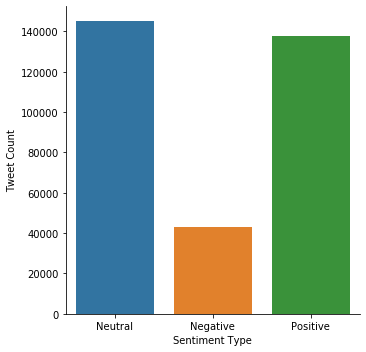

In [15]:
sentimentPdDf = tweetSentiment.select("text", "label").toPandas()

ax = sns.catplot(x="label", kind="count", data=sentimentPdDf) 
plt.ylabel("Tweet Count")
plt.xlabel("Sentiment Type")
plt.show()

In [16]:
dateCount = tweetSentiment.select("date")
dateCount = dateCount.select("date", month("date").alias("months"), year("date").alias("years"))
dateCount = dateCount.where("years>2019")
dateCount = dateCount.groupBy(date_format("date", "MM/yy").alias("timeline"), "months", "years")\
                     .count().alias("count")\
                     .orderBy(dateCount.years.asc(),dateCount.months.asc())

dataCnt = dateCount.toPandas()

labelCount = tweetSentiment.select("date", date_format("date", "MM/yy").alias("timeline"),
                                  month("date").alias("months"), year("date").alias("years"), "label")
labelCount = labelCount.where("years>2019")

#----------------------Negative Labels-------------------------------------------#
negCount = labelCount.filter(labelCount["label"] == "Negative")

negCount = negCount.groupBy("timeline", "months", "years")\
                   .count().alias("count")\
                   .orderBy(negCount.years.asc(),negCount.months.asc())
negdata = negCount.toPandas()

#----------------------Positive Labels-------------------------------------------#
posCount = labelCount.filter(labelCount["label"] == "Positive")

posCount = posCount.groupBy("timeline", "months", "years")\
                 .count().alias("count")\
                 .orderBy(posCount.years.asc(),posCount.months.asc())
posdata = posCount.toPandas()

#----------------------Neutral Labels-------------------------------------------#
neuCount = labelCount.filter(labelCount["label"] == "Neutral")

neuCount = neuCount.groupBy("timeline", "months", "years")\
                   .count().alias("count")\
                   .orderBy(neuCount.years.asc(),neuCount.months.asc())
neudata = neuCount.toPandas()

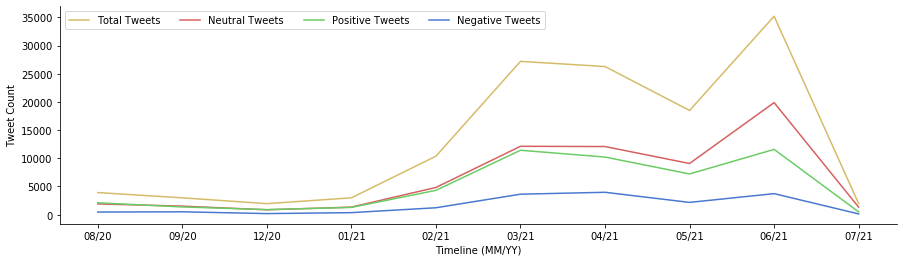

In [17]:
f, ax = plt.subplots(figsize= (15,4))
sns.set_color_codes('dark')
sns.lineplot(y="count", x="timeline", data=dataCnt, color = 'y', label="Total Tweets", sort=False)
sns.set_color_codes('colorblind')
sns.lineplot(y="count", x="timeline", data=neudata, color = 'r', label="Neutral Tweets", sort=False)
sns.set_color_codes('pastel')
sns.lineplot(y="count", x="timeline", data=posdata, color = 'g', label="Positive Tweets", sort=False)
sns.set_color_codes('muted')
sns.lineplot(y="count", x="timeline", data=negdata, color = 'b', label="Negative Tweets", sort=False)
ax.legend(ncol = 4, loc = 'upper left')
sns.despine(left=False, bottom=False)
plt.ylabel("Tweet Count")
plt.xlabel("Timeline (MM/YY)")
plt.show()

# Word Cloud Analysis

In [18]:
def word_cloud_tweets(dataframe, filter_words=()):
    dataframe = dataframe.select('text').toPandas().text
    if filter_words:
        dataframe = [text for text in dataframe if any([filter_word in text for filter_word in filter_words])]
    
    text = ' '.join(dataframe)
    
    stopwords = STOPWORDS.union(set(filter_words))
    
    # Generate the image
    wordcloud = WordCloud(stopwords=stopwords, background_color="white", max_words=100).generate(text)
    return wordcloud

In [19]:
def count_tags(dataframe):
    hashData = dataframe
    
    hashData = dataframe.withColumn("hashtags",regexp_replace(dataframe.hashtags, "\]", ''))
    hashData = hashData.withColumn("hashtags",regexp_replace(hashData.hashtags, "\[", ''))
    hashData = hashData.withColumn("hashtags",regexp_replace(hashData.hashtags, "\'", ''))
    hashData = hashData.withColumn("hashtags",split(hashData.hashtags, ','))

    hashDF = hashData.withColumn("hashtags",explode(hashData.hashtags))

    hashDF = hashDF.withColumn("hashtags",ltrim(hashDF.hashtags))
    hashDF = hashDF.withColumn("hashtags",lower(hashDF.hashtags))
    hashDF = hashDF.groupBy(hashDF.hashtags)\
                     .count()
    hashDF = hashDF.select("*").orderBy(hashDF['count'].desc())
    
    return hashDF

In [20]:
def word_cloud_hashtags(dataframe, stopWordList):
    stopWord = STOPWORDS.union(stopWordList)
    
    hashDF = count_tags(dataframe)
    
    data = hashDF.select("hashtags").limit(50).toPandas().hashtags
    text = ""
    text = ' '.join(data)
    
    wordcloud = WordCloud(stopwords=stopWord, width=400, height=400, background_color='white').generate(text)
    return wordcloud

In [21]:
stopList = ['vaccine', 'covid', 'vaccination', 'covidvaccine', 'covid19', 'coronavirus', 'covid 19', 'vaccines', 'people', 
            'covidvaccine', 'covid19vaccine', 'vaccine', 'covidãƒ¼19', 'á', 'covid19vaccination', 'covid_19', 'one', 's', 
            'app', 'via', 'u', 'take', 'dont', 'put', 'say', 'see', 'will', 'uk', 'now', 'way','web', 'android', 'twitter', 
            'already', 'done', 'year', 'today', 'even', 'let', 'give', 'go', 'im', 'now', 'amp', 'd1', 'd2', '1410rs', 'india', 'got']

In [22]:
cleanText = tweetSentiment.select('text', "label")
negdata = cleanText.select("text")\
                   .filter(cleanText.label == "Negative")

posdata = cleanText.select("text")\
                   .filter(cleanText.label == "Positive")

neudata = cleanText.select("text")\
                   .filter(cleanText.label == "Neutral")

poscloud = word_cloud_tweets(posdata, stopList)
negcloud = word_cloud_tweets(negdata, stopList)
neucloud = word_cloud_tweets(neudata, stopList)

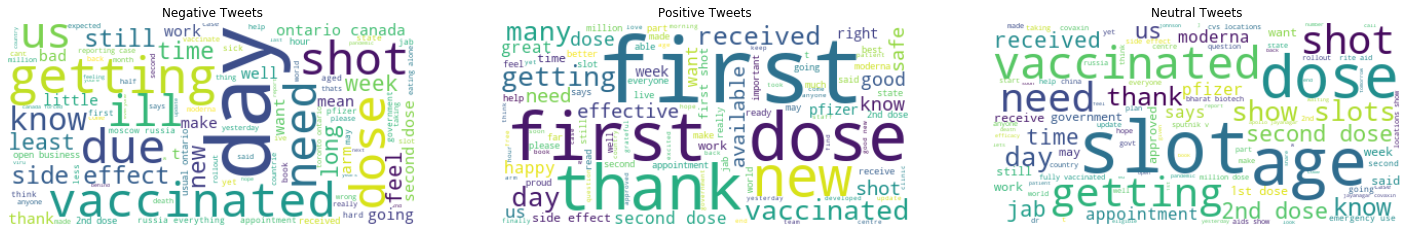

In [23]:
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(25,10))
ax[0].set_title("Negative Tweets")
ax[0].imshow(negcloud, interpolation='bilinear')
ax[0].axis("off")

ax[1].set_title("Positive Tweets")
ax[1].imshow(poscloud, interpolation='bilinear')
ax[1].axis("off")

ax[2].set_title("Neutral Tweets")
ax[2].imshow(neucloud, interpolation='bilinear')
ax[2].axis("off")

plt.show()

In [24]:
stopList = ['vaccine', 'covid', 'vaccination', 'covidvaccine', 'covid19', 'coronavirus', 'covid 19', 'vaccines', 'people', 
            'covidvaccine', 'covid19vaccine', 'vaccine', 'covidãƒ¼19', 'á', 'covid19vaccination', 'covid_19', 'one', 's', 
            'app', 'via', 'u', 'take', 'dont', 'put', 'say', 'see', 'will', 'uk', 'now', 'way','web', 'android', 'twitter', 
            'already', 'done', 'year', 'today', 'even', 'let', 'give', 'go', 'im', 'now', 'amp', 'd1', 'd2', '1410rs']

In [25]:
hashDist = tweetSentiment.select("hashtags", "label", date_format("date", "MM/yy").alias("timeline")).dropna()
hashNeg0321 = hashDist.select("hashtags")\
                      .filter(hashDist["label"] == "Negative")\
                      .filter(hashDist["timeline"] == "03/21")

hashNeg0421 = hashDist.select("hashtags")\
                      .filter(hashDist["label"] == "Negative")\
                      .filter(hashDist["timeline"] == "04/21")

In [26]:
wcNeg0321 = word_cloud_hashtags(hashNeg0321, stopList)
wcNeg0421 = word_cloud_hashtags(hashNeg0421, stopList)

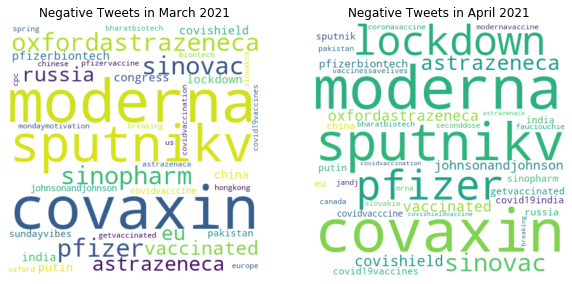

In [30]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax[0].set_title("Negative Tweets in March 2021")
ax[0].imshow(wcNeg0321, interpolation='bilinear')
ax[0].axis("off")

ax[1].set_title("Negative Tweets in April 2021")
ax[1].imshow(wcNeg0421, interpolation='bilinear')
ax[1].axis("off")

plt.show()

In [28]:
Text = tweetSentiment.select("ogtext", date_format("date", "MM/yy").alias("timeline"), "label", "hashtags")

Text.select(Text.ogtext.alias("tweet"),"hashtags")\
    .filter(Text.label == "Negative")\
    .filter(Text.timeline == "04/21")\
    .filter(Text.hashtags.contains('oxford'))\
    .show(9,False,True)

-RECORD 0---------------------------------------------------------------------------------------------------------------------------------------------------
 tweet    | Want to know why EU countries have constantly tried to undermine the #OxfordAstraZeneca vaccine? Unfortunately this...¦ https://t.co/RXjpgmKSmh 
 hashtags | ['oxfordastrazeneca']                                                                                                                           
-RECORD 1---------------------------------------------------------------------------------------------------------------------------------------------------
 tweet    | Blimey

A rare side effect of taking ibuprofen - is heart failure ðŸ˜®

#oxfordastrazeneca #AstraZeneca #vaccination #COVID19                   
 hashtags | ['oxfordastrazeneca', 'astrazeneca', 'vaccination', 'covid19']                                                                                  
-RECORD 2-------------------------------------------------

In [29]:
Text.select(Text.ogtext.alias("tweet"),"hashtags")\
    .filter(Text.label == "Positive")\
    .filter(Text.timeline == "04/21")\
    .filter(Text.hashtags.contains('oxford'))\
    .show(9,False,True)

-RECORD 0------------------------------------------------------------------------------------------------------------------------------------------------------
 tweet    | @chidinmaekile Good morning ma #oxfordastrazeneca                                                                                                  
 hashtags | ['oxfordastrazeneca']                                                                                                                              
-RECORD 1------------------------------------------------------------------------------------------------------------------------------------------------------
 tweet    | @EMA_News Great slide from Prof. Jonathan Van Tam ( UK GOV) which puts in perspective #OxfordAstraZeneca side effec...¦ https://t.co/UFfTbwKdse    
 hashtags | ['oxfordastrazeneca']                                                                                                                              
-RECORD 2-------------------------------